In [1]:
from dotenv import load_dotenv
import os, sys

sys.path.append(os.path.join(os.getcwd(), '..', '..'))

load_dotenv()

True

# Retriever Tool
- Chroma와 `BAAI/bge-m3` 이용

In [2]:
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

vectorstore = Chroma(
    persist_directory="./chatbot_20251108",
    embedding_function=HuggingFaceEmbeddings(model_name="BAAI/bge-m3"),
)
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 5}
)

c:\Users\Lee JinSeoung\OneDrive\Desktop\4학년 1학기\캡스톤디자인\chatbot-api\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Langchain prebuilt `create_retriever_tool` 이용하여 retriever tool 생성

In [3]:
from langchain_classic.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    name="retrieve_kongju_national_university_info",
    description="Search and return information about 국립공주대학교",
    retriever=retriever,
)

- retriever_tool 테스트

In [4]:
retriever_tool.invoke({"query": "소프트웨어학과 수강과목 알려줘"})

'[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 신호 및 시스템 과목은 3학점으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 웹프로그래밍 과목은 3학점(4시간 강의)으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 모바일프로그래밍 과목은 3학점(4시간 강의)으로 3학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 시스템분석설계 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 컴퓨터비전 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 컴퓨터그래픽스 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 클라우드컴퓨팅 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 IT실무영어 과목은 3학점으로 3학년 2학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 가상현실 과목은 3학점으로 4학년 1학기에 수강한다.\n[소프트웨어학과 교육과정표 2025~2029년도 입학자 적용] 전공 (93학점), 전공 핵심 (18학점)인 분산컴퓨팅 과목은 3학점으로 4학년 2학기에 수강한다.\n\n[소프트웨어학과 교육과정표 2020년도 입학자 적용] 핵심교양 (3학점)인 선택 과목은

- LLM에 tool로 바인딩

In [5]:
from langchain_openai import ChatOpenAI

from src.agent.state import CustomState

model = ChatOpenAI(
    model="gpt-5-nano",
    temperature=0,
)

def generate_query_or_respond(state: CustomState):
    response = (
        model.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

In [6]:
# 단순 응답 제공
input = {
    "messages": [
        {
            "role": "user",
            "content": "안녕하세요",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요! 무엇을 도와드릴까요?

다양한 도움을 드릴 수 있어요. 예시로는:
- 국립공주대학교(Kongju National University) 관련 최신 정보 검색
- 일반知识 질의에 대한 답변
- 번역 및 문장 교정
- 글쓰기 피드백 및 아이디어 정리
- 코딩 도움이나 문제 해결
- 공부 계획 세우기, 일정 관리

원하시는 주제가 있다면 말씀해 주세요. 바로 시작해서 도와드리겠습니다.


In [7]:
# semantic search 결과 제공

input_with_retrieval = {
    "messages": [
        {
            "role": "user",
            "content": "소프트웨어학과 4학년 수강과목 알려줘",
        }
    ]
}
generate_query_or_respond(input_with_retrieval)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_kongju_national_university_info (call_97MUPe6vKGVMNVjm84hHReW8)
 Call ID: call_97MUPe6vKGVMNVjm84hHReW8
  Args:
    query: 공주대학교 소프트웨어학과 4학년 수강 과목


# Document Relevancy Checker
- 검색된 문서가 질문과 연관되어 있는지 LLM 기반으로 판단

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
    "If score is 'no', show why it is not relevant in brief.\n"
)


class GradeDocuments(BaseModel):  
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )

def grade_documents(
    state: CustomState
) -> Literal["generate", "rewrite_question"]:
    question = state["messages"][-1].content
    context = state.get("documents")

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        model.with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )

    score = response.binary_score.strip().lower()
    return "generate" if score == "yes" else "rewrite_question"


# Human-in-the-loop
- 인간이 개입하여 작업을 명료화함

In [9]:
HITL_PROMPT = (
    "Answer the following sentence:\n\n"
    "제공하신 질문에 대한 답변을 드리기 위해 추가 정보가 필요합니다. 학과, 연도 등 세부 정보를 포함하여 질문을 구체적으로 작성해 주세요.\n\n"
    "Answer in {language}. If 'ko', use Korean. If 'en', use English."
    "Do not answer anything else."
)

def rewrite_question(state: CustomState):
    language = state.get("language", "ko")
    prompt = HITL_PROMPT.format(language=language)
    response = model.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

# Build Graph
- 구현한 tool과 node를 이용하여 그래프 연결

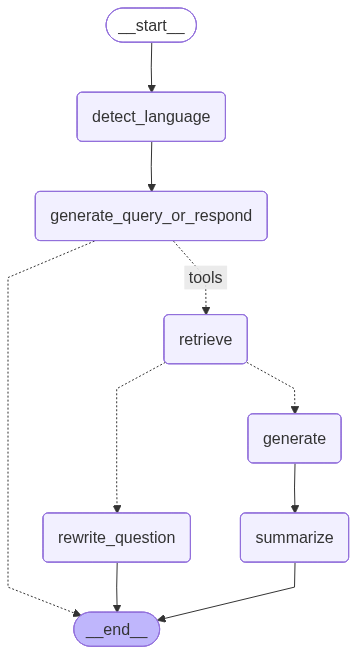

In [10]:
from src.agent.nodes import language_detection_node, generation_node, summarization_node
from src.agent.graph import visualize_graph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver  

checkpointer = InMemorySaver()
builder = StateGraph(CustomState)

builder.add_node("detect_language", language_detection_node)
builder.add_node(generate_query_or_respond)
builder.add_node("retrieve", ToolNode([retriever_tool]))
builder.add_node("rewrite_question", rewrite_question)
builder.add_node("generate", generation_node)
builder.add_node("summarize", summarization_node)

builder.add_edge(START, "detect_language")
builder.add_edge("detect_language", "generate_query_or_respond")
builder.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    }
)
builder.add_conditional_edges(
    "retrieve",
    grade_documents,
)
builder.add_edge("generate", "summarize")
builder.add_edge("rewrite_question", END)
builder.add_edge("summarize", END)

graph = builder.compile(checkpointer=checkpointer)
visualize_graph(graph)

- 그래프 실행

In [11]:
from langchain_core.runnables import RunnableConfig

config: RunnableConfig = {
    "configurable": {
        "thread_id": 123 
    }
}

def pretty_print_messages(config: RunnableConfig, query):
    for chunk in graph.stream(query, config=config):
        for node, output in chunk.items():
            print(f"Node: {node}")
            if "messages" in output and output["messages"]:
                output["messages"][-1].pretty_print()

In [12]:
query = {
    "messages": [
        {
            "role": "user",
            "content": "소프트웨어학과 4학년 수강과목 알려줘",
        }
    ]
}

pretty_print_messages(config=config, query=query)

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_kongju_national_university_info (call_qJ51yED3jZYA8L3fMAZJ0BqR)
 Call ID: call_qJ51yED3jZYA8L3fMAZJ0BqR
  Args:
    query: 국립공주대학교 소프트웨어학과 4학년 수강과목
Node: retrieve
================================= Tool Message =================================
Name: retrieve_kongju_national_university_info

수강신청은 강의나 실험·실습을 듣기 위해 자신이 이수할 교과목을 선택하여 신청하는 것이다.
5페이지
교육과정은 교양필수, 교양선택, 전공, 융합탐색 등으로 구성되어 있으며 각 항목의 학점과 비고는 다음과 같다. 교양필수의 기초교양필수는 10학점으로 공주대학교 학생들이 공통으로 이수해야 하는 교양과목이다. 교양선택에는 기초교양선택 14학점이 포함되며 이는 소프트웨어학과 학생들이 수강해야 하는 교양과목이고, 균형교양선택은 12학점으로 공과대학 학생들이 수강해야 하는 교양과목이다. 소양교양필수는 0학점으로 우리 학과 학생은 수강해서는 안 된다. 전공에서는 전공기초가 63학점으로 소프트웨어학과 학생들이 필수로 이수해야 하는 과목들이며, 전공핵심은 18학점 이상으로 소프트웨어학과 학생들이 수강해야 하는 전공과목이다. 융합탐색은 1~13학점 범위의 타학과 전공과목이다. 졸업학점 합계는 최소 130학점으로 졸업을 위한 기준이다.
6페이지
4. 수강신청하기
가. 수강신청 일정 안내  
자세한 내용은 공주대학교 홈페이지 정보광장 공지사항(https://www.kongju.ac.kr/bb

In [13]:
query_2 = {
    "messages": [
        {
            "role": "user",
            "content": "2025년 정보를 원해",
        }
    ]
}

pretty_print_messages(config=config, query=query_2)

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================

다음은 2025년 공지된 교육과정표에 따른 소프트웨어학과 4학년 수강과목 요약입니다.

- 4학년 1학기
  - 정보보안 과목 — 3학점
  - 미래설계Ⅴ — 0학점

- 4학년 2학기
  - 캡스톤디자인프로젝트Ⅱ — 3학점
  - 미래설계Ⅵ — 0학점

비고
- 위 내용은 2025~2029년도 입학자 적용 교육과정표에 따른 예정 과목 구성입니다.
- 0학점 과목은 학점 취득에 직접 반영되지는 않으므로, 전체 졸업학점(최소 130학점) 관리에 유의하시길 바랍니다.
- 실제 개설 여부, 과목 코드/강의시간표 등은 학과 공지나 수강신청 페이지에서 최종 확인이 필요합니다.

원하시면 4학년 각 학기의 구체적인 과목 코드나 교수명, 강의시간표까지 추가로 정리해 드리겠습니다. 또한 2025년 수강신청 일정도 정리해 드릴 수 있어요.


In [14]:
query_3 = {
    "messages": [
        {
            "role": "user",
            "content": "Hello, how are you?",
        }
    ]
}

pretty_print_messages(config=config, query=query_3)

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================

Hello! I’m an AI, so I don’t have feelings, but I’m here and ready to help.

How can I assist you today? If you’d like, I can:
- Provide 2025 소프트웨어학과 4학년 수강과목 details in English (with semester, credits, and any notes).
- Add course codes, instructors, and timetable information (if available).
- Summarize or translate previous Korean info into English.
- Help with the 2025 수강신청 일정 or any other related details.

What would you like to see?


In [15]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='소프트웨어학과 4학년 수강과목 알려줘', additional_kwargs={}, response_metadata={}, id='20e73860-9a36-4e48-9174-ee4f38df60e1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qJ51yED3jZYA8L3fMAZJ0BqR', 'function': {'arguments': '{"query":"국립공주대학교 소프트웨어학과 4학년 수강과목"}', 'name': 'retrieve_kongju_national_university_info'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 367, 'prompt_tokens': 160, 'total_tokens': 527, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CazPNz09ElVqEOBdWGQFjwLtSETqF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--a772c33e-5fc5-4353-9a94-782b55c50470-0', tool_calls=[{'name':

In [16]:
query_4 = {
    "messages": [
        {
            "role": "user",
            "content": "참여 기관은 어떻게 찾아서 신청할 수 있나요?",
        }
    ]
}

pretty_print_messages(config=config, query=query_4)

Node: detect_language
Node: generate_query_or_respond
================================== Ai Message ==================================

참여 기관(산학협력 기업/연구기관 등)에 찾아가서 신청하는 방법은 학교의 공식 채널을 먼저 확인하고, 그다음 직접 접근하는 순서로 진행하는 게 일반적입니다. 아래 단계별 가이드를 참고해 보세요.

1) 원하는 유형 정리
- 인턴십(현장 실무 경험)
- 학과 프로젝트의 협력기관(캡스톤디자인 등)
- 연구 참여(교수 연구실, 산학연구 과제)
- 현장 실습/방학 프로그램
목적에 따라 목표 기관의 범위를 정합니다.

2) 학교의 공식 채널 확인
- 학과 홈페이지/정보광장(공지사항)에서 산학협력 공고나 협력기관 목록을 확인
- 대학의 산학협력단/취업지원센터 페이지에 실습, 인턴십, 프로젝트 협력 공지가 있는지 확인
- 수강신청 포털이나 학사 공지(연계과목, 현장실습 과목 안내)도 같이 확인
- 지역 캠퍼스(예: 천안캠퍼스)나 학과 커뮤니티의 공지사항도 놓치지 않기
- 필요 시 학과 사무실이나 산학협력 담당자에게 문의

3) 목표 기관 목록 작성
- 관심 분야(예: AI/데이터, 모바일 앱, 웹 서비스, 임베디드 등)별로 8–15곳 정도 예비 목록 만들기
- 지역 기업, 공공기관, 연구소, 스타트업까지 폭넓게 포함
- 각 기관의 협력 가능 분야와 신청 방법을 간단히 메모

4) 지원 자료 준비
- 이력서(학력, 프로젝트 경험, 기술 스택 정리)
- 자기소개서나 지원 동기서(기관별 맞춤형으로 약간씩 수정)
- 포트폴리오 또는 프로젝트 요약(가능하면 링크 포함)
- 학점/수료 요건, 필요 서류(추천서 등) 파악
- 면담용 발표 자료나 간단한 프로젝트 소개 자료 미리 준비

5) 신청 방법 파악 및 접촉
- 대부분 온라인 양식, 이메일 제출, 또는 현장 방문 방식으로 진행
- 기관의 채용/협력 담당자에게 공식 이메일로 문의하는 것이 좋습